*First compiled: May 2, 2017.*

## Myeloid progenitors of data of Paul *et al.*, Cell. (2015)

Hematopoiesis: trace myeloid and erythroid differentiation for data of [Paul *et al.*, (2015)](http://doi.org/10.1016/j.cell.2015.11.013).

In [1]:
%config InlineBackend.figure_formats = ['retina']  # increase resolution on retina screens
import numpy as np
import matplotlib.pyplot as pl
import scanpy.api as sc

sc.settings.verbosity = 3                # amount of output
sc.settings.set_dpi(80)                  # low pixel number yields small inline figures
sc.logging.print_version_and_date()

Running Scanpy version 0.2 on 2017-07-24 00:32.


Get the raw gene expression.

In [2]:
def paul15_raw():
    filename = 'data/paul15/paul15.h5'
    backup_url = 'http://falexwolf.de/data/paul15.h5'
    adata = sc.read(filename, 'data.debatched', backup_url=backup_url)
    # each row has to correspond to a sample, therefore transpose                                                                                                               
    adata = adata.transpose()    # cluster assocations identified by Paul et al.
    clusters = sc.read(filename, 'cluster.id', return_dict=True)['X'].flatten()
    # names reflecting the cell type identifications from the paper
    cell_types = {i: 'Ery' for i in range(1, 7)}
    cell_types[7] = 'MEP'
    cell_types[8] = 'Mk'
    cell_types[9] = 'GMP'
    cell_types[10] = 'GMP'
    cell_types[11] = 'DC'
    cell_types[12] = 'Baso'
    cell_types[13] = 'Baso'
    cell_types[14] = 'Mo'
    cell_types[15] = 'Mo'
    cell_types[16] = 'Neu'
    cell_types[17] = 'Neu'
    cell_types[18] = 'Eos'
    cell_types[19] = 'Other'
    adata.smp['paul15_clusters'] = [str(i) + cell_types[i] for i in clusters.astype(int)]
    infogenes_names = sc.read(filename, 'info.genes_strings', return_dict=True)['X']
    # just keep the first of the two equivalent names per gene                                                                                                                       
    adata.var_names = np.array([gn.split(';')[0] for gn in adata.var_names])
    # remove 10 corrupted gene names                                                                                                                                                 
    infogenes_names = np.intersect1d(infogenes_names, adata.var_names)
    # restrict the data to the 3461 informative genes                                                                                                                              
    adata = adata[:, infogenes_names]
    adata.add['iroot'] = np.flatnonzero(adata.smp['paul15_clusters']  == '7MEP')[0]
    return adata

### Simple DPT analysis

Perform a Diffusion Pseudotime analysis on raw data, as in [Haghverdi *et al.* (2016)](http://doi.org/10.1038/nmeth.3971). No preprocessing, only logarthmize the raw counts.

In [3]:
adata = paul15_raw()
# logarithmize data
sc.pp.log1p(adata)
# set root cell as in Haghverdi et al. (2016)                                                                                                                                    
adata.add['iroot'] = 840  # note that other than in Matlab/R, counting starts at 1

reading sheet data.debatched from file data/paul15/paul15.h5
reading sheet cluster.id from file data/paul15/paul15.h5
reading sheet info.genes_strings from file data/paul15/paul15.h5


In [4]:
sc.tl.dpt(adata, n_branchings=1, n_neighbors=20, n_pcs=0)

initializing data graph with `n_neighbors=20`
    using data matrix X directly for building graph (no PCA)
computing Diffusion Map with 10 components
    eigenvalues of transition matrix
    [ 1.     0.992  0.966  0.94   0.927  0.886  0.867  0.841  0.829  0.807]
perform Diffusion Pseudotime analysis
    detect 1 branching
    do not consider groups with less than 27 points for splitting
    branching 1: split group 0
finished (0:00:00.747) and added
    "dpt_pseudotime", the pseudotime (adata.smp),
    "dpt_groups", the branching subgroups of dpt (adata.smp)
    "dpt_order", order according to groups and increasing pseudtime (adata.smp)


Diffusion Pseudotime (DPT) analysis detects the branch of granulocyte/macrophage progenitors (GMP), and the branch of megakaryocyte/erythrocyte progenitors (MEP). There are two small further subgroups (segments 0 and 2).

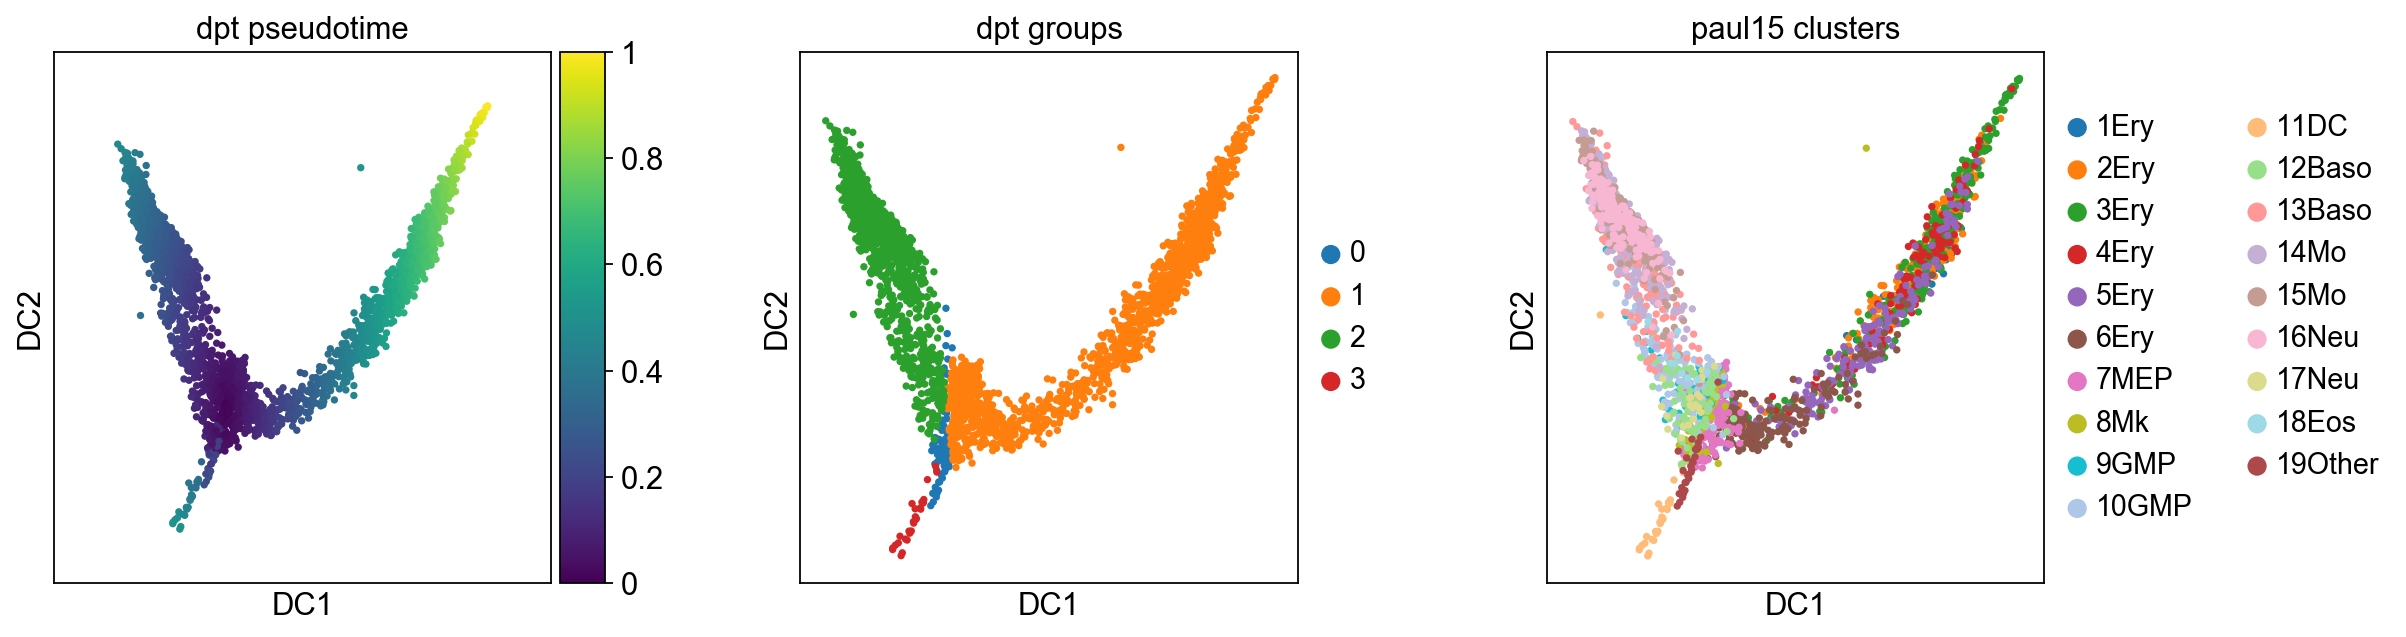

In [5]:
sc.pl.dpt_scatter(adata, color=['dpt_pseudotime', 'dpt_groups', 'paul15_clusters'])

With this, we reproduced the analysis of [Haghverdi *et al.* (2016, Suppl. Note 4 and Suppl. Figure N4)](https://doi.org/10.1038/nmeth.3971).

Save the results.

In [14]:
sc.write('paul15', adata)

... writing ./write/paul15.h5


### Visualize with tSNE

It's always to good, to look at a second visualization.

In [6]:
sc.tl.tsne(adata)

compute tSNE
    preprocess using PCA with 50 PCs
--> avoid this by setting n_pcs = 0
    using 50 principal components
    using package MulticoreTSNE
    finished (0:00:07.795) and added
    "X_tsne", tSNE coordinates (adata.smp)


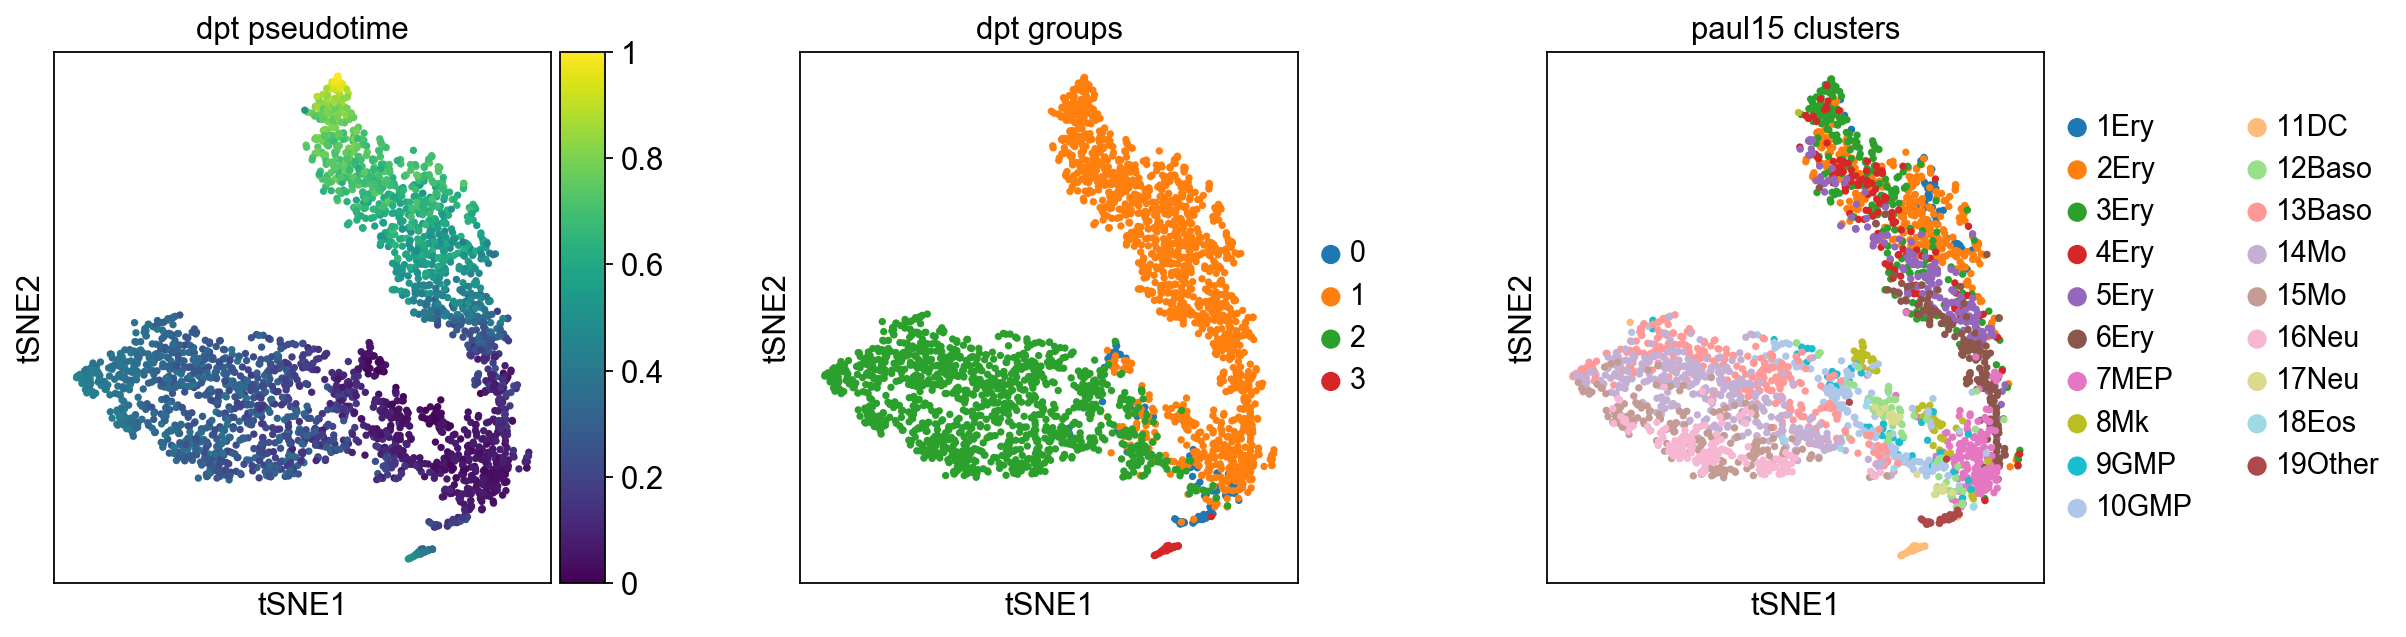

In [7]:
axs = sc.pl.tsne(adata, color=['dpt_pseudotime', 'dpt_groups', 'paul15_clusters'])

### Using a preprocessing recipe

To make the geometry of the data pronounced, select highly variable genes as done by [Zheng *et al.*, (2017)](http://doi.org/10.1038/ncomms14049).

In [8]:
adata = paul15_raw()
sc.pp.recipe_zheng17(adata)

reading sheet data.debatched from file data/paul15/paul15.h5
reading sheet cluster.id from file data/paul15/paul15.h5
reading sheet info.genes_strings from file data/paul15/paul15.h5
... filtered out 0 genes that are detected with less than 1 counts
... filtered out 0 cells that have less than 1 counts
... normalizing by total count per cell (0:00:00.013)
... filter highly varying genes by dispersion and mean (0:00:00.078)
    the 1000 top genes correspond to a normalized dispersion cutoff of 1.06631
... filtered out 0 cells that have less than 1 counts
... normalizing by total count per cell (0:00:00.004)


Let us compute the tSNE coordinates for visualization.

In [9]:
sc.tl.tsne(adata)

compute tSNE
    preprocess using PCA with 50 PCs
--> avoid this by setting n_pcs = 0
    using 50 principal components
    using package MulticoreTSNE
    finished (0:00:07.702) and added
    "X_tsne", tSNE coordinates (adata.smp)


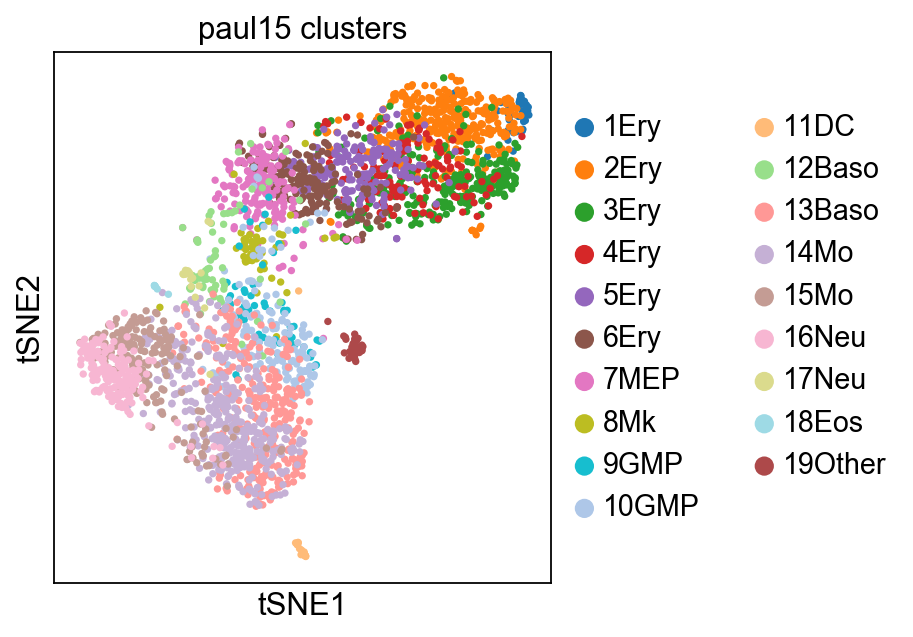

In [11]:
axs = sc.pl.tsne(adata, color=['paul15_clusters'])

Detect the single branching into myeloids and erythroids.

In [12]:
sc.tl.dpt(adata, n_branchings=1, n_neighbors=20)

initializing data graph with `n_neighbors=20`
    using X_pca for building graph
computing Diffusion Map with 10 components
    eigenvalues of transition matrix
    [ 1.     0.99   0.968  0.956  0.939  0.913  0.879  0.875  0.867  0.841]
perform Diffusion Pseudotime analysis
    detect 1 branching
    do not consider groups with less than 27 points for splitting
    branching 1: split group 0
finished (0:00:00.771) and added
    "dpt_pseudotime", the pseudotime (adata.smp),
    "dpt_groups", the branching subgroups of dpt (adata.smp)
    "dpt_order", order according to groups and increasing pseudtime (adata.smp)


Now DPT finds the branch of dendritic cells.

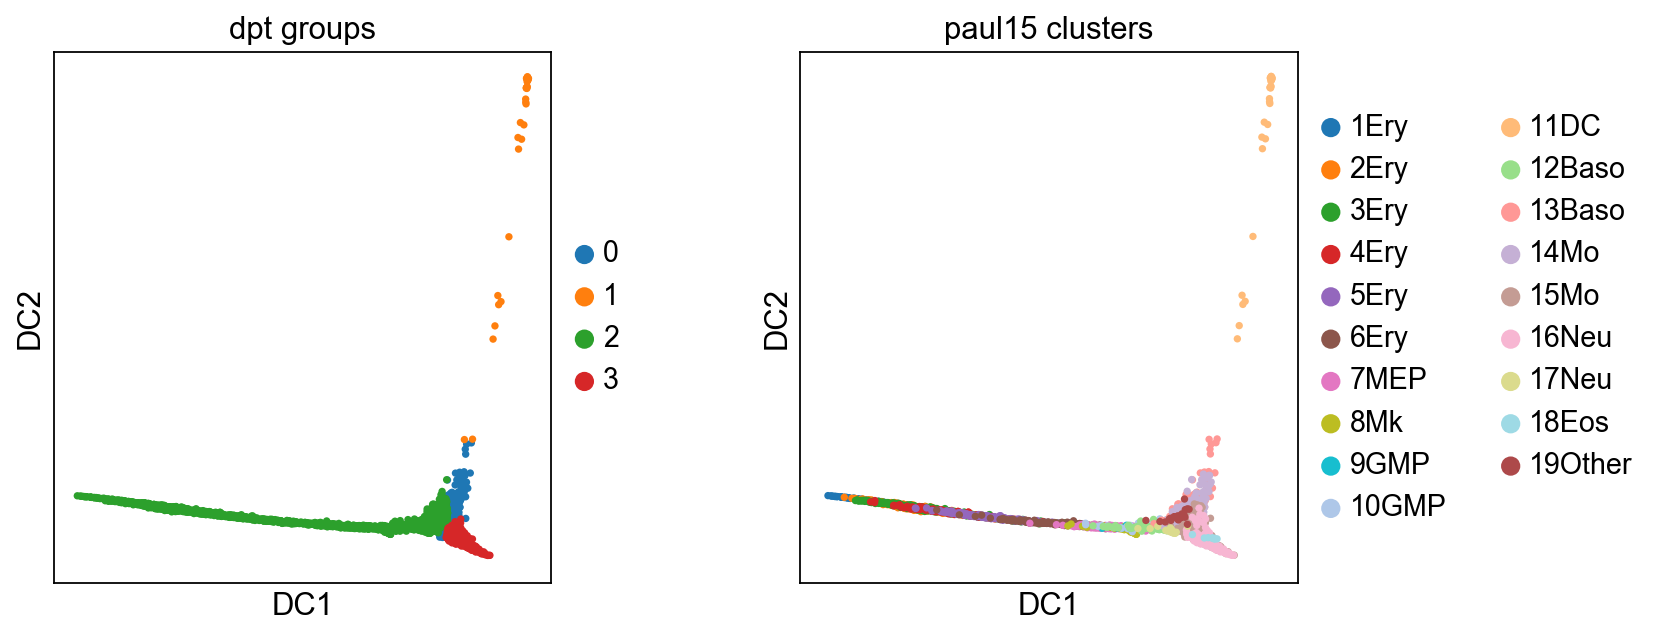

In [15]:
axs = sc.pl.diffmap(adata, color=['dpt_groups', 'paul15_clusters'])

Unfortunately, all other branches seem to composed quite arbitrarly.

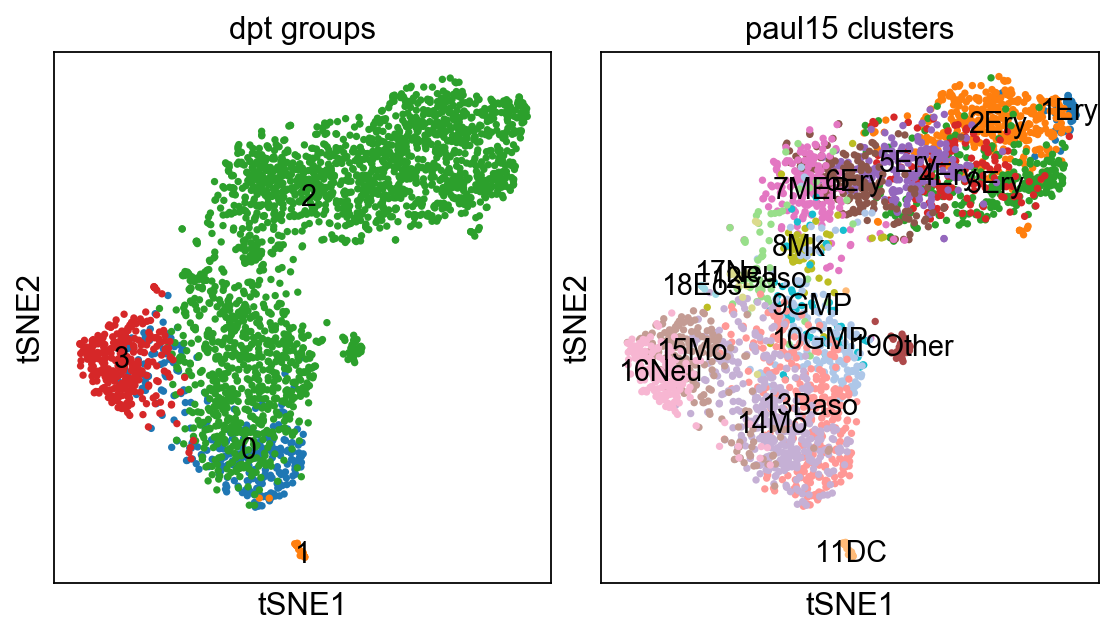

In [17]:
axs = sc.pl.tsne(adata, color=['dpt_groups', 'paul15_clusters'], legend_loc='on data')

Saving the results.

In [14]:
sc.write('paul15', adata)

... writing ./write/paul15.h5
